# Dynamic Pricing for Multiple Products

In [1]:
import math
import operator
import itertools
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

%matplotlib inline

## Konstanten

In [2]:
# General parameters
min_price = 1
max_price = 20
price_step = 0.5
product_range = range(2)
a_ranges = [np.arange(min_price, max_price + price_step, price_step) for i in product_range]
C = 5
C_range = range(C)

# Regression parameters
B = 1000
B_range = range(B)

# Optimization parameters
delta = 0.99

# Simulation parameters
T = 500

## Simulierte Daten

In [3]:
def generate_prices(price_range, count):
    return np.random.choice(price_range, count)

def generate_p(price_range):
    return np.array([generate_prices(price_range, B) for j in C_range])
    
def calculate_ranks(a, p):
    return [1 + len([1 for j in C_range if p[j, k] < a[k]])
            for k in B_range]

a_index = {}
for price in a_ranges[0]:
    a_index[price] = int(price / price_step - min_price / price_step)

In [4]:
a = np.array([generate_prices(a_ranges[i], B) for i in product_range]) 
p = np.array([generate_p(a_ranges[i]) for i in product_range])
r = np.array([calculate_ranks(a[i], p[i]) for i in product_range])

In [5]:
def calculate_P_1(a, r):
    max_prob = lambda i: 1 - ((0.3 * r[0, i]) / (C+ 1)) - \
                         0.05 * a[0, i] + \
                         (-0.0125 * (a[0, i] - a[1, i]) + 0.25)
            
    return [max(0, round(np.random.uniform(0, max_prob(i)))) for i in B_range]

def calculate_P_2(a, r):
    max_prob = lambda i: 1 - ((0.3 * r[1, i]) / (C+ 1)) - \
                         0.05 * a[1, i] + \
                         (0.0125 * (a[0, i] - a[1, i]) + 0.25)
            
    return [max(0, round(np.random.uniform(0, max_prob(i)))) for i in B_range]

In [6]:
P = [calculate_P_1(a, r), calculate_P_2(a, r)]

## Regression

In [7]:
def get_all_p(observation):
    for i in product_range:
            for j in C_range:
                yield p[i, j, observation]
                
def get_x(product, r, p):
    explanatory_1 = [1] * B
    explanatory_2 = [r[product, k] for k in B_range]
    explanatory_3 = [a[product, k] - min(get_all_p(k)) for k in B_range]
    explanatory_4 = [a[product, k] - min(a[i, k] for i in product_range) for k in B_range]
    explanatory_5 = list(map(lambda x: math.pow(x, 2),explanatory_4))
    
    return np.matrix([explanatory_1, explanatory_2, explanatory_3, explanatory_4, explanatory_5])

In [8]:
def fit_model(x, P):
    regressor = LogisticRegression(fit_intercept=False)
    model = regressor.fit(x.transpose(), P)
    coeffs = model.coef_[0].tolist()

    return coeffs

x = [get_x(i, r, p) for i in product_range]
beta = [fit_model(x[i], P[i]) for i in product_range]
print('betas: ' + str(beta))

betas: [[1.1280691429343852, -0.4615210262808973, -0.1457753104792441, -0.04100417398707192, -0.018071893089555976], [0.8402971601047626, -0.22394435030883186, -0.1871473106470377, -0.2573495945661191, -0.017447374252620256]]


## Optimierung

In [9]:
# Generate competitor prices for new, specific situation
p = np.array([generate_prices(a_ranges[i], C) for i in product_range])
print('competitor prices: ' + str(p))

competitor prices: [[ 20.    3.    9.    1.5  14. ]
 [  9.   10.5   5.   19.5   7. ]]


### Recreate explanatory vars depending on price combinations

In [10]:
min_p = min_price
def calculate_min_p():
    global min_p
    min_p = np.min(p) 

def get_x_replica_1(p):
    explanatory_1 = np.array([[1] * len(a_ranges[0])] * len(a_ranges[1]))
    explanatory_2 = np.array([[1 + len([1 for j in C_range if p[0, j] < a_1]) 
                               for a_2 in a_ranges[1]] for a_1 in a_ranges[0]])
    explanatory_3 = np.array([[a_1 - min_p
                               for a_2 in a_ranges[1]] for a_1 in a_ranges[0]])
    explanatory_4 = np.array([[a_1 - a_2
                                for a_2 in a_ranges[1]] for a_1 in a_ranges[0]])
    explanatory_5 = np.array([[math.pow(explanatory_4[a_index[a_1], a_index[a_2]], 2) 
                                for a_2 in a_ranges[1]] for a_1 in a_ranges[0]])
    
    return np.array([explanatory_1, explanatory_2, explanatory_3, explanatory_4, explanatory_5])

def get_x_replica_2(p):
    explanatory_1 = np.array([[1] * len(a_ranges[0])] * len(a_ranges[1]))
    explanatory_2 = np.array([[1 + len([1 for j in C_range if p[1, j] < a_2]) 
                               for a_2 in a_ranges[1]] for a_1 in a_ranges[0]])
    explanatory_3 = np.array([[a_2 - min_p
                               for a_2 in a_ranges[1]] for a_1 in a_ranges[0]])
    explanatory_4 = np.array([[a_2 - a_1
                                for a_2 in a_ranges[1]] for a_1 in a_ranges[0]])
    explanatory_5 = np.array([[math.pow(explanatory_4[a_index[a_1], a_index[a_2]], 2) 
                                for a_2 in a_ranges[1]] for a_1 in a_ranges[0]])
    
    return np.array([explanatory_1, explanatory_2, explanatory_3, explanatory_4, explanatory_5])


def update_x_replica_1_for_simulation(p, x_1):
    explanatory_2 = np.array([[1 + len([1 for j in C_range if p[0, j] < a_1]) 
                               for a_2 in a_ranges[1]] for a_1 in a_ranges[0]])
    explanatory_3 = np.array([[a_1 - min_p 
                               for a_2 in a_ranges[1]] for a_1 in a_ranges[0]])

    return np.array([x_1[0], explanatory_2, explanatory_3, x_1[3], x_1[4]])

def update_x_replica_2_for_simulation(p, x_2):
    explanatory_2 = np.array([[1 + len([1 for j in C_range if p[1, j] < a_2]) 
                               for a_2 in a_ranges[1]] for a_1 in a_ranges[0]])
    explanatory_3 = np.array([[a_2 - min_p
                               for a_2 in a_ranges[1]] for a_1 in a_ranges[0]])

    return np.array([x_2[0], explanatory_2, explanatory_3, x_2[3], x_2[4]])

In [11]:
calculate_min_p()
x = [get_x_replica_1(p), get_x_replica_2(p)]

### Calculate sale probabilities with betas

In [12]:
def calculate_P(beta, x):
    P = np.empty(shape=(2, 2, len(a_ranges[0]), len(a_ranges[1])))
    for i in product_range:
        for a_1 in a_ranges[0]:
            for a_2 in a_ranges[1]:
                L = sum([beta[i][l] * x[i][l, a_index[a_1], a_index[a_2]] for l in range(len(beta[i]))])
                p = np.exp(L) / (1 + np.exp(L))
                P[0, i, a_index[a_1], a_index[a_2]] = 1 - p
                P[1, i, a_index[a_1], a_index[a_2]] = p
    return P

In [13]:
P = calculate_P(beta, x)

### Calculate optimal prices using Bellman

In [14]:
def get_event_combinations(n):
        possibile_events = [[0] if n[i] == 0 else [0,1] for i in product_range]
        return itertools.product(*possibile_events)

In [15]:
def bellman(P):
    V = np.empty(shape=(len(a_ranges[0]),len(a_ranges[1])))
    for a_1 in a_ranges[0]:
        for a_2 in a_ranges[1]:
            a = [a_1, a_2]
            result = 1/(1-delta) * sum(sum(P[k, j, a_index[a[0]], a_index[a[1]]] * k * a[j] for k in product_range) for j in product_range)
            V[a_index[a_1]][a_index[a_2]] = result
    argmax = np.unravel_index(V.argmax(), V.shape)
    opt_a_1 = a_ranges[0][argmax[0]]
    opt_a_2 = a_ranges[1][argmax[1]]
    opt_a = [opt_a_1, opt_a_2]
        
    return opt_a, V

In [16]:
opt_a, V = bellman(P)
print('optimal price combination: ' + str(opt_a))
print('maximum expected profit: ' + str(V[a_index[opt_a[0]]][a_index[opt_a[1]]]))

optimal price combination: [9.0, 7.0]
maximum expected profit: 480.136927634


### 3D Visualization for Expected Profit of  Price Combinations

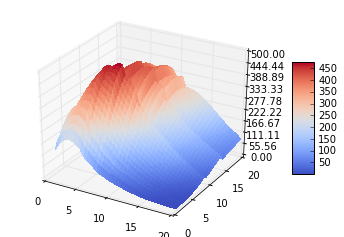

In [17]:
fig = plt.figure()
axes = fig.gca(projection = '3d')
X,Y = np.meshgrid(a_ranges[0], a_ranges[1])
Z = V

surf = axes.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

axes.zaxis.set_major_locator(LinearLocator(10))
axes.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## Simulation

In [18]:
# Competitor prices over the time period
p_time = np.zeros(shape=(T, 2, C))
for i in product_range:
    for j in C_range:
        p_time[0, i, j] = p[0, j]
        
# Own prices over the time period
a_time = np.zeros(shape=(T, 2))
a_time[0, 0] = opt_a[0]
a_time[0, 1] = opt_a[1]

# count number of sales
product_sales = np.zeros(shape=(T, 2))
profit_time = np.zeros(shape=(T, 2))
expected_profit = np.zeros(shape=(T))

# Naive Prices
naive_a_time = np.zeros(shape=(T, 2))
naive_a_time[0, 0] = max(min_price, np.min(p_time[0,0]) - price_step)
naive_a_time[0, 1] = max(min_price, np.sort(p_time[0,1])[1] - price_step)
naive_product_sales = np.zeros(shape=(T, 2))
naive_profit_time = np.zeros(shape=(T, 2))
naive_expected_profit = np.zeros(shape=(T))

In [19]:
for t in range(1, T):
    for i in product_range:
        # own sales for previous period
        sale_prob = P[i, 1, a_index[a_time[t - 1, 0]], a_index[a_time[t - 1,1]]]
        if np.random.uniform(0, 1) < sale_prob:
            product_sales[t, i] = product_sales[t-1, i] + 1
            profit_time[t, i] = profit_time[t-1, i] + a_time[t-1, i]
        else:
            product_sales[t, i] = product_sales[t-1, i]
            profit_time[t, i] = profit_time[t-1, i]
        expected_profit[t] = V[a_index[a_time[t - 1, 0]], a_index[a_time[t - 1, 1]]]
        naive_expected_profit[t] = V[a_index[naive_a_time[t - 1, 0]], a_index[naive_a_time[t - 1, 1]]]
        
        # naive sales for previous period    
        naive_sale_prob = P[i, 1, a_index[naive_a_time[t - 1, 0]], a_index[naive_a_time[t - 1,1]]]
        if np.random.uniform(0, 1) < naive_sale_prob:
            naive_product_sales[t, i] = naive_product_sales[t-1, i] + 1
            naive_profit_time[t, i] = naive_profit_time[t-1, i] + naive_a_time[t-1, i]
        else:
            naive_product_sales[t, i] = naive_product_sales[t-1, i]
            naive_profit_time[t, i] = naive_profit_time[t-1, i]
    
        # vary competitor prices
        calculate_bellman_again = False
        for j in C_range:
            if np.random.uniform(0, 1) < 0.1:
                boost = np.random.uniform(0.8, 1.2)
                p_time[t, i, j] = min(max_price, round(p_time[t - 1, i, j] * boost, 1))
                calculate_bellman_again = True
            else:
                p_time[t, i, j] = p_time[t-1, i, j]
                
    # adjust own prices for next period        
    if calculate_bellman_again:
        calculate_min_p()
        x = [update_x_replica_1_for_simulation(p_time[t], x[0]), update_x_replica_2_for_simulation(p_time[t], x[1])]
        P = calculate_P(beta, x)
        opt_a, V = bellman(P)
        a_time[t, 0] = opt_a[0]
        a_time[t, 1] = opt_a[1]
    else:
        a_time[t, 0] = a_time[t-1, 0]
        a_time[t, 1] = a_time[t-1, 1]
            
    # adjust naive prices for next period
    naive_a_time[t, 0] = max(min_price, round((np.min(p_time[t,0]) - price_step) * 2) / 2)
    naive_a_time[t, 1] = max(min_price, round((np.sort(p_time[t,1])[1] - price_step) * 2) / 2)

### Plots

In [20]:
# own strategy
swap_a_time = np.swapaxes(a_time, 0,1)
swap_product_sales = np.swapaxes(product_sales, 0,1)
swap_profit_time = np.swapaxes(profit_time, 0,1)

# naive strategy
swap_naive_a_time = np.swapaxes(naive_a_time, 0,1)
swap_naive_product_sales = np.swapaxes(naive_product_sales, 0,1)
swap_naive_profit_time = np.swapaxes(naive_profit_time, 0,1)

swap_p_time = np.swapaxes(p_time, 0,2)

#### Prices over time

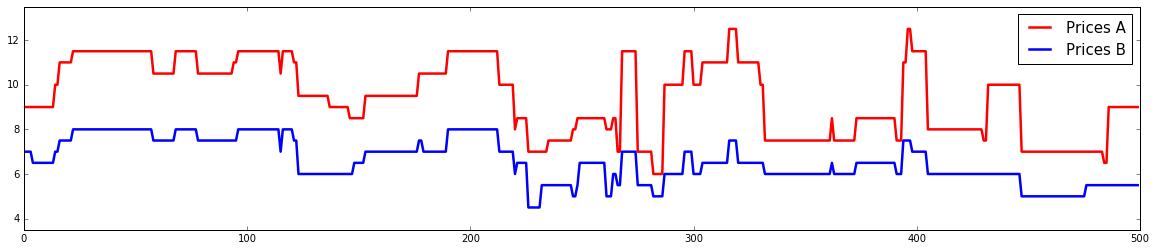

In [21]:
plt.figure(figsize=(20, 4))
plt.plot(range(T), swap_a_time[0], label='Prices A', color="red", linewidth=2.5)
plt.plot(range(T), swap_a_time[1], label='Prices B', color="blue", linewidth=2.5)
plt.axis([0, T, min(min(swap_a_time[0]), min(swap_a_time[1])) - 1, max(max(swap_a_time[0]), max(swap_a_time[1])) + 1])
plt.legend(loc='upper right', prop={'size': 15})
plt.show()

#### Sales over time

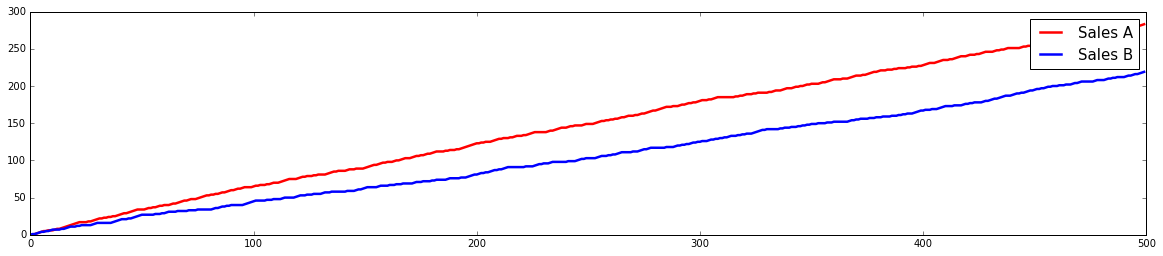

In [22]:
plt.figure(figsize=(20, 4))
plt.plot(range(T), swap_product_sales[0], label='Sales A', color="red", linewidth=2.5)
plt.plot(range(T), swap_product_sales[1], label='Sales B', color="blue", linewidth=2.5)
plt.legend(loc='upper right', prop={'size': 15})
plt.show()

#### Product 1: Own Prices and Competitor Prices

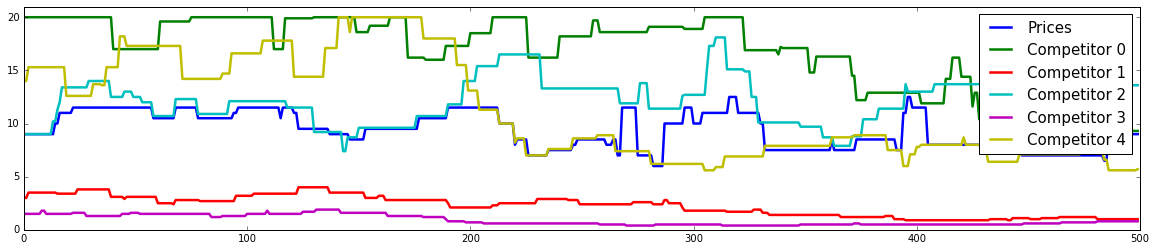

In [23]:
plt.figure(figsize=(20, 4))
plt.plot(range(T), swap_a_time[0], label='Prices', linewidth=2.5)
for competitor in C_range:
    plt.plot(range(T), swap_p_time[competitor][0], label='Competitor '+str(competitor), linewidth=2.5)
plt.axis([0, T, min_price - 1, max_price + 1])
plt.legend(loc='upper right', prop={'size': 15})
plt.show()

#### Product 2: Own Prices and Competitor Prices

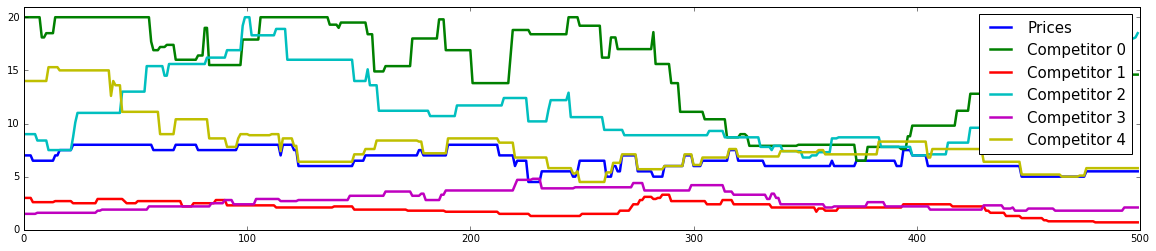

In [24]:
plt.figure(figsize=(20, 4))
plt.plot(range(T), swap_a_time[1], label='Prices', linewidth=2.5)
for competitor in C_range:
    plt.plot(range(T), swap_p_time[competitor][1], label='Competitor '+str(competitor), linewidth=2.5)

plt.axis([0, T, min_price - 1, max_price + 1])
plt.legend(loc='upper right', prop={'size': 15})
plt.show()

#### Profit

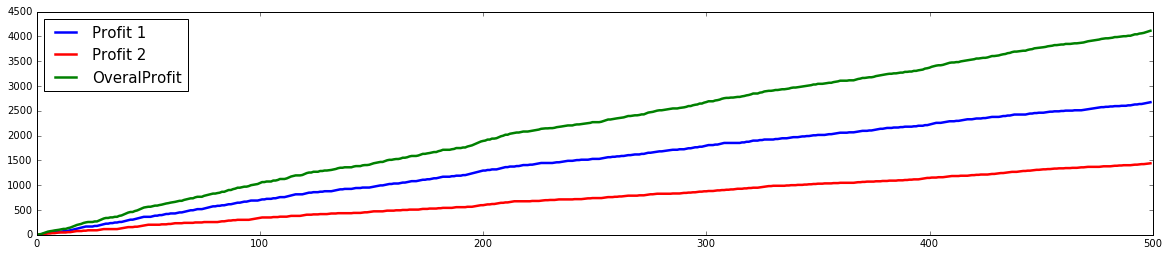

In [25]:
plt.figure(figsize=(20, 4))
plt.plot(range(T), swap_profit_time[0], label='Profit 1', color="blue", linewidth=2.5)
plt.plot(range(T), swap_profit_time[1], label='Profit 2', color="red", linewidth=2.5)
plt.plot(range(T), np.sum(profit_time,1), label='OveralProfit', color="green", linewidth=2.5)
plt.legend(loc='upper left', prop={'size': 15})
plt.show()

#### Compare to Naive Strategy: Profit

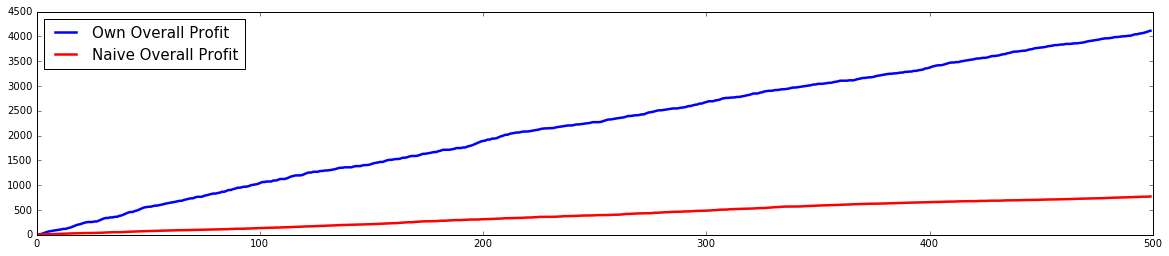

In [26]:
plt.figure(figsize=(20, 4))
plt.plot(range(T), np.sum(profit_time,1), label='Own Overall Profit', color="blue", linewidth=2.5)
plt.plot(range(T), np.sum(naive_profit_time,1), label='Naive Overall Profit', color="red", linewidth=2.5)
plt.legend(loc='upper left', prop={'size': 15})
plt.show()

#### Compare to Naive Strategy: Expected Profit

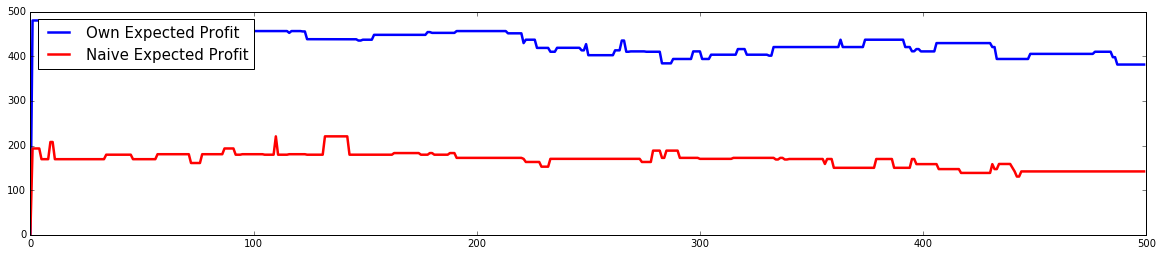

In [27]:
plt.figure(figsize=(20, 4))
plt.plot(range(T), expected_profit, label='Own Expected Profit', color="blue", linewidth=2.5)
plt.plot(range(T), naive_expected_profit, label='Naive Expected Profit', color="red", linewidth=2.5)
plt.legend(loc='upper left', prop={'size': 15})
plt.show()